# Install MongoDB & Load Data

In [1]:
!apt install mongodb > /dev/null
from pymongo import MongoClient
import pandas as pd

In [2]:
!service mongodb start

 * Starting database mongodb
   ...done.


In [3]:
!wget -q https://raw.githubusercontent.com/ashutoshpradhan7/BDNS-Real/main/Churn_data.json

In [4]:
!mongoimport --jsonArray --db PraxisDB --collection Churn_data --drop --file Churn_data.json

2023-02-05T16:47:48.136+0000	connected to: localhost
2023-02-05T16:47:48.136+0000	dropping: PraxisDB.Churn_data
2023-02-05T16:47:48.356+0000	imported 10000 documents


In [5]:
mongoURI = "mongodb://localhost:27017/"    # local
client = MongoClient(mongoURI)
client.list_database_names() 

['PraxisDB', 'admin', 'config', 'local']

In [6]:
db = client.PraxisDB
db.list_collection_names()

['Churn_data']

In [7]:
table = db.Churn_data
table.count_documents({})

10000

# EDA

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
#View whole data as dataframe
df = pd.DataFrame(list(db.Churn_data.find()))
df

,_id,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,63df88f15eaf6876c272b022,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
1,63df88f15eaf6876c272b023,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
2,63df88f15eaf6876c272b024,619,France,Female,42,2,0.00,1,1,1,101348.88,1
3,63df88f15eaf6876c272b025,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,63df88f15eaf6876c272b026,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,63df88f15eaf6876c272d736,771,France,Male,39,5,0.00,2,1,0,96270.64,0
9996,63df88f15eaf6876c272d737,516,France,Male,35,10,57369.61,1,1,1,101699.77,0
9997,63df88f15eaf6876c272d738,709,France,Female,36,7,0.00,1,0,1,42085.58,1
9998,63df88f15eaf6876c272d739,772,Germany,Male,42,3,75075.31,2,1,0,92888.52,1


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   _id              10000 non-null  object 
 1   CreditScore      10000 non-null  int64  
 2   Geography        10000 non-null  object 
 3   Gender           10000 non-null  object 
 4   Age              10000 non-null  int64  
 5   Tenure           10000 non-null  int64  
 6   Balance          10000 non-null  float64
 7   NumOfProducts    10000 non-null  int64  
 8   HasCrCard        10000 non-null  int64  
 9   IsActiveMember   10000 non-null  int64  
 10  EstimatedSalary  10000 non-null  float64
 11  Exited           10000 non-null  int64  
dtypes: float64(2), int64(7), object(3)
memory usage: 937.6+ KB


In [ ]:
df['Tenure'].value_counts()

2     1048
1     1035
7     1028
8     1025
5     1012
3     1009
4      989
9      984
6      967
10     490
0      413
Name: Tenure, dtype: int64

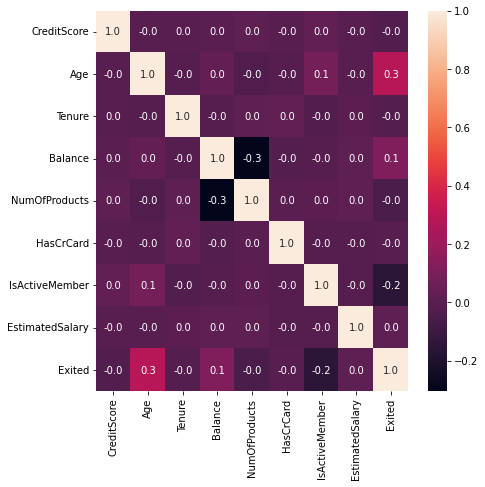

In [ ]:
#Correlation Heatmap
plt.figure(figsize=(7,7))
sns.heatmap (df.corr(),annot=True , fmt=".1f")

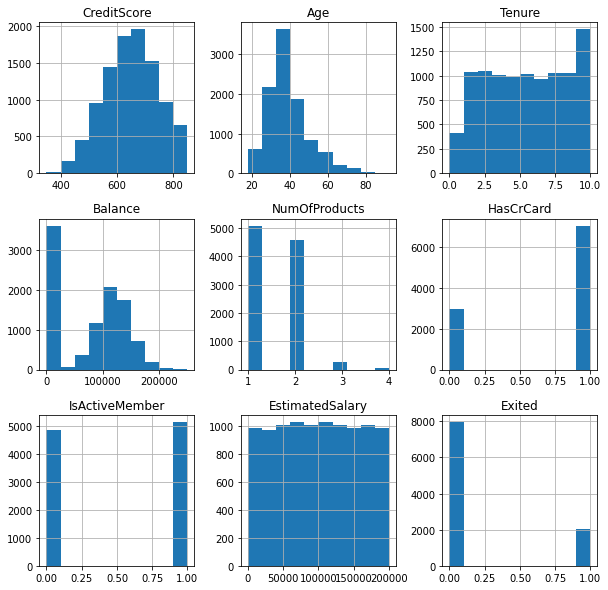

In [ ]:
#Histogram of Numerical Variables
plt.rcParams['figure.figsize'] = (10,10)
df.hist()
plt.show()

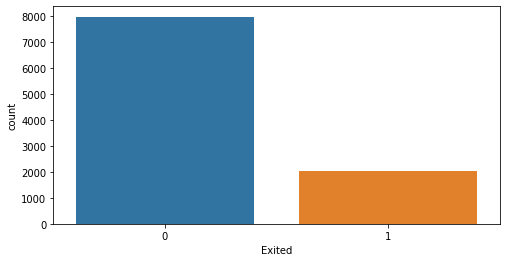

In [ ]:
#Count Plot of the Target Variable
plt.rcParams['figure.figsize'] = (8,4)
sns.countplot(x='Exited', data = df)

# Install Spark and Transfer Data

In [ ]:
!pip3 install -q pyspark

In [ ]:
from pyspark.sql import SparkSession
spark = SparkSession \
    .builder \
    .master("local[*]") \
    .config("spark.mongodb.input.uri", "mongodb://localhost:27017/sparkDB.coll01") \
    .config("spark.mongodb.output.uri", "mongodb://localhost:27017/sparkDB.coll01") \
    .config('spark.jars.packages', 'org.mongodb.spark:mongo-spark-connector_2.12:3.0.1')\
    .getOrCreate()

In [ ]:
sparkDF = spark.read.format("mongo").option("uri","mongodb://127.0.0.1/PraxisDB.Churn_data").load()
sparkDF.show()

+---+---------+-----------+---------------+------+------+---------+---------+--------------+-------------+------+--------------------+
|Age|  Balance|CreditScore|EstimatedSalary|Exited|Gender|Geography|HasCrCard|IsActiveMember|NumOfProducts|Tenure|                 _id|
+---+---------+-----------+---------------+------+------+---------+---------+--------------+-------------+------+--------------------+
| 41| 83807.86|        608|      112542.58|     0|Female|    Spain|        0|             1|            1|     1|{63df88f15eaf6876...|
| 42| 159660.8|        502|      113931.57|     1|Female|   France|        1|             0|            3|     8|{63df88f15eaf6876...|
| 42|      0.0|        619|      101348.88|     1|Female|   France|        1|             1|            1|     2|{63df88f15eaf6876...|
| 39|      0.0|        699|       93826.63|     0|Female|   France|        0|             0|            2|     1|{63df88f15eaf6876...|
| 43|125510.82|        850|        79084.1|     0|Femal

In [ ]:
sparkDF = sparkDF.drop("_id")
sparkDF.printSchema()

root
 |-- Age: integer (nullable = true)
 |-- Balance: double (nullable = true)
 |-- CreditScore: integer (nullable = true)
 |-- EstimatedSalary: double (nullable = true)
 |-- Exited: integer (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Geography: string (nullable = true)
 |-- HasCrCard: integer (nullable = true)
 |-- IsActiveMember: integer (nullable = true)
 |-- NumOfProducts: integer (nullable = true)
 |-- Tenure: integer (nullable = true)



In [ ]:
sparkDF.show()

+---+---------+-----------+---------------+------+------+---------+---------+--------------+-------------+------+
|Age|  Balance|CreditScore|EstimatedSalary|Exited|Gender|Geography|HasCrCard|IsActiveMember|NumOfProducts|Tenure|
+---+---------+-----------+---------------+------+------+---------+---------+--------------+-------------+------+
| 41| 83807.86|        608|      112542.58|     0|Female|    Spain|        0|             1|            1|     1|
| 42| 159660.8|        502|      113931.57|     1|Female|   France|        1|             0|            3|     8|
| 42|      0.0|        619|      101348.88|     1|Female|   France|        1|             1|            1|     2|
| 39|      0.0|        699|       93826.63|     0|Female|   France|        0|             0|            2|     1|
| 43|125510.82|        850|        79084.1|     0|Female|    Spain|        1|             1|            1|     2|
| 44|113755.78|        645|      149756.71|     1|  Male|    Spain|        1|           

# Data Preprocessing

In [ ]:
sparkDF.toPandas().isnull().sum()

Age                0
Balance            0
CreditScore        0
EstimatedSalary    0
Exited             0
Gender             0
Geography          0
HasCrCard          0
IsActiveMember     0
NumOfProducts      0
Tenure             0
dtype: int64

# Feature Engineering

In [ ]:
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler
from pyspark.ml import Pipeline

In [ ]:
Gender_indexer = StringIndexer(inputCol='Gender',outputCol='Gender_num')
Geography_indexer = StringIndexer(inputCol='Geography',outputCol='Geography_num')
HasCrCard_indexer = StringIndexer(inputCol='HasCrCard',outputCol='HasCrCard_num')
IsActiveMember_indexer = StringIndexer(inputCol='IsActiveMember',outputCol='IsActiveMember_num')
NumOfProducts_indexer = StringIndexer(inputCol='NumOfProducts',outputCol='NumOfProducts_num')
Tenure_indexer = StringIndexer(inputCol='Tenure',outputCol='Tenure_num')
encoder = OneHotEncoder(inputCols=["Gender_num","Geography_num","HasCrCard_num","IsActiveMember_num","NumOfProducts_num","Tenure_num"],
                       outputCols=["Gender_vector","Geography_vector","HasCrCard_vector","IsActiveMember_vector","NumOfProducts_vector","Tenure_vector"])

In [ ]:
assembler=VectorAssembler(inputCols=["Age","Balance","CreditScore","EstimatedSalary","Gender_num","Geography_num","HasCrCard_num","IsActiveMember_num","NumOfProducts_num","Tenure_num"]
                          ,outputCol='features')
standard_scaler = StandardScaler(inputCol="features", outputCol="features_scaled")

In [ ]:
basepipe = Pipeline(stages=[Gender_indexer, Geography_indexer, HasCrCard_indexer, IsActiveMember_indexer,NumOfProducts_indexer,Tenure_indexer,
                            encoder, assembler, standard_scaler])

In [ ]:
basepipe.fit(sparkDF).transform(sparkDF).select(['features_scaled','Exited']).show(5, False)

+----------------------------------------------------------------------------------------------------------------------------------------------------------------+------+
|features_scaled                                                                                                                                                 |Exited|
+----------------------------------------------------------------------------------------------------------------------------------------------------------------+------+
|[3.9093017390053144,1.3431305312804156,6.290525082437989,1.9569051574074903,2.0083062457076424,2.416832769221561,2.1937499584452778,0.0,0.0,0.34151135425037593]|0     |
|[4.004650561907883,2.5587730688822763,5.19382169635505,1.9810570978960365,2.0083062457076424,0.0,0.0,2.0008126162027735,3.438468177012218,1.024534062751128]    |1     |
|(10,[0,2,3,4],[4.004650561907883,6.4043339243899915,1.762267632121752,2.0083062457076424])                                                           

# Spark ML Pipelines 

In [ ]:
dfTrain, dfTest = sparkDF.randomSplit([0.75,0.25])
print(dfTrain.count(), dfTest.count())

7521 2479


In [ ]:
dfTrain.groupBy('Exited').count().show()

+------+-----+
|Exited|count|
+------+-----+
|     1| 1532|
|     0| 5989|
+------+-----+



In [ ]:
dfTest.groupBy('Exited').count().show()

+------+-----+
|Exited|count|
+------+-----+
|     1|  505|
|     0| 1974|
+------+-----+



In [ ]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.evaluation import BinaryClassificationEvaluator

## Logistic Regression Pipeline 

In [ ]:
logreg = LogisticRegression(labelCol='Exited',featuresCol='features_scaled',maxIter=6)
logreg_pipeline = Pipeline(stages=[basepipe,logreg])
logreg_model = logreg_pipeline.fit(dfTrain)
logreg_predictions=logreg_model.transform(dfTest)

In [ ]:
acc_evaluator = MulticlassClassificationEvaluator(labelCol="Exited", predictionCol="prediction", metricName="accuracy")
evaluator = BinaryClassificationEvaluator(labelCol='Exited')

In [ ]:
logreg_acc=acc_evaluator.evaluate(logreg_predictions)
print(round(logreg_acc*100,2), 'is the accuracy of the Logistic Regression Pipeline')
logreg_auroc = evaluator.evaluate(logreg_predictions, {evaluator.metricName: "areaUnderROC"})
print("Area under ROC Curve: {:.4f}".format(logreg_auroc))

80.48 is the accuracy of the Logistic Regression Pipeline
Area under ROC Curve: 0.7434


## Random Forest Pipeline

In [ ]:
from pyspark.ml.classification import RandomForestClassifier

In [ ]:
ranfor = RandomForestClassifier(featuresCol='features_scaled', labelCol='Exited')
ranfor_pipeline = Pipeline(stages=[basepipe, ranfor])
ranfor_model = ranfor_pipeline.fit(dfTrain)
ranfor_predictions=ranfor_model.transform(dfTest)

In [ ]:
ranfor_acc=acc_evaluator.evaluate(ranfor_predictions)
print(round(ranfor_acc*100,2), 'is the accuracy of the Random Forest Pipeline')
ranfor_auroc = evaluator.evaluate(ranfor_predictions, {evaluator.metricName: "areaUnderROC"})
print("Area under ROC Curve: {:.4f}".format(ranfor_auroc))

85.52 is the accuracy of the Random Forest Pipeline
Area under ROC Curve: 0.8242


## Gradient Boost Pipeline

In [ ]:
from pyspark.ml.classification import GBTClassifier

In [ ]:
gbt = GBTClassifier(featuresCol='features_scaled', labelCol='Exited')
gbt_pipeline = Pipeline(stages=[basepipe, gbt])
gbt_model = gbt_pipeline.fit(dfTrain)
gbt_predictions=gbt_model.transform(dfTest)

In [ ]:
gbt_acc=acc_evaluator.evaluate(gbt_predictions)
print(round(gbt_acc*100,2), 'is the accuracy of the Gradient Boost Pipeline')
gbt_auroc = evaluator.evaluate(gbt_predictions, {evaluator.metricName: "areaUnderROC"})
print("Area under ROC Curve: {:.4f}".format(gbt_auroc))

85.48 is the accuracy of the Gradient Boost Pipeline
Area under ROC Curve: 0.8544


# Comparison of the Models

In [ ]:
print(round(logreg_acc*100,2), 'is the accuracy of the Logistic Regression Pipeline')
print(round(ranfor_acc*100,2), 'is the accuracy of the Random Forest Pipeline')
print(round(gbt_acc*100,2), 'is the accuracy of the Gradient Boost Pipeline')

80.48 is the accuracy of the Logistic Regression Pipeline
85.52 is the accuracy of the Random Forest Pipeline
85.48 is the accuracy of the Gradient Boost Pipeline


In [ ]:
print("Area under ROC Curve for Logistic Regression : {:.4f}".format(logreg_auroc))
print("Area under ROC Curve for Random Forest       : {:.4f}".format(ranfor_auroc))
print("Area under ROC Curve for Gradient Boost      : {:.4f}".format(gbt_auroc))

Area under ROC Curve for Logistic Regression : 0.7434
Area under ROC Curve for Random Forest       : 0.8242
Area under ROC Curve for Gradient Boost      : 0.8544


*Random Forest gives us the best result as compared to GBM. Hence, it can be used to predict future churn.*